Seeing what's possible with two variables (2d chart)

In [67]:
import logging

import os
import sys
root_dir = os.path.abspath(os.path.join(os.path.dirname('__file__'), '../..'))
sys.path.append(root_dir)

import numpy as np
import pandas as pd

from importlib import reload

from memory import garbage_collect

log = lambda msg: logging.info(msg)


# Load data

In [68]:
!pip install dotenv

In [69]:
from sleep_events import load_days_data

day_data = load_days_data(True)

In [70]:
[c for c in day_data.columns if 'dayAndNightOf' in c]


['dayAndNightOf', 'fitbit:heartrate:dayAndNightOf']

In [125]:
col1 = 'events:shower:lastSSM'
col2 = 'circadian:combined:entries:LEP:datetimeSSM'
c1 = 'shower'
c2 = 'LEP'

columns_to_select = [col1, col2]

df = day_data.copy()[columns_to_select]
df.index = day_data['dayAndNightOf']
import notebooks.Util.Time as Time
reload(Time)
df = Time.convert_cols_to_hours(df)


df[c1] = df[col1.replace(':lastSSM', ':last')]
df[c2] = df[col2.replace(':datetimeSSM', ':datetime')]
df.drop(columns=[col1.replace(':lastSSM', ':last'), col2.replace(':datetimeSSM', ':datetime')], inplace=True)

# Circadian data just gets better here. As I'm doing morning walks.
df = df[df.index >= '2024-08-14']
df = df[df[c1].notna() & df[c2].notna()]
df['Diff'] = df[c1] - df[c2]


df.head()
# df.fillna({"events:shower:lastSSM": 0, 
#            "events:shower:firstSSM": 0,
#            'events:shower:durationSecs': 0}, inplace=True)




,shower,LEP,Diff
dayAndNightOf,,,
2024-08-18,14.766667,22.366667,-7.600000
2024-08-26,15.416667,21.200000,-5.783333
2024-09-15,18.250000,21.400000,-3.150000
2024-09-18,21.166667,21.933333,-0.766667
2024-09-28,18.833333,21.866667,-3.033333


In [72]:
!pip install matplotlib seaborn scipy


# Simple correlations

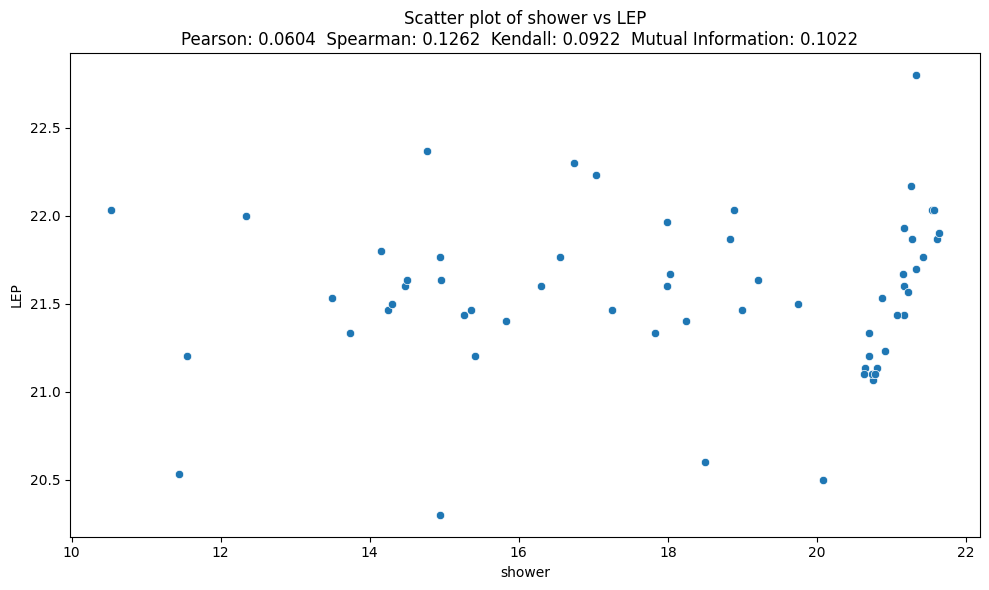

AttributeError: 'Series' object has no attribute 'categories'

<Figure size 1000x600 with 0 Axes>

In [126]:
import stats_two_variables
reload(stats_two_variables)

results = stats_two_variables.calculate_correlations(df, c1, c2)
stats_two_variables.visualize_scatter(df, c1, c2, results)
stats_two_variables.visualize_joint_plot(df, c1, c2)
stats_two_variables.print_correlation_results(results)

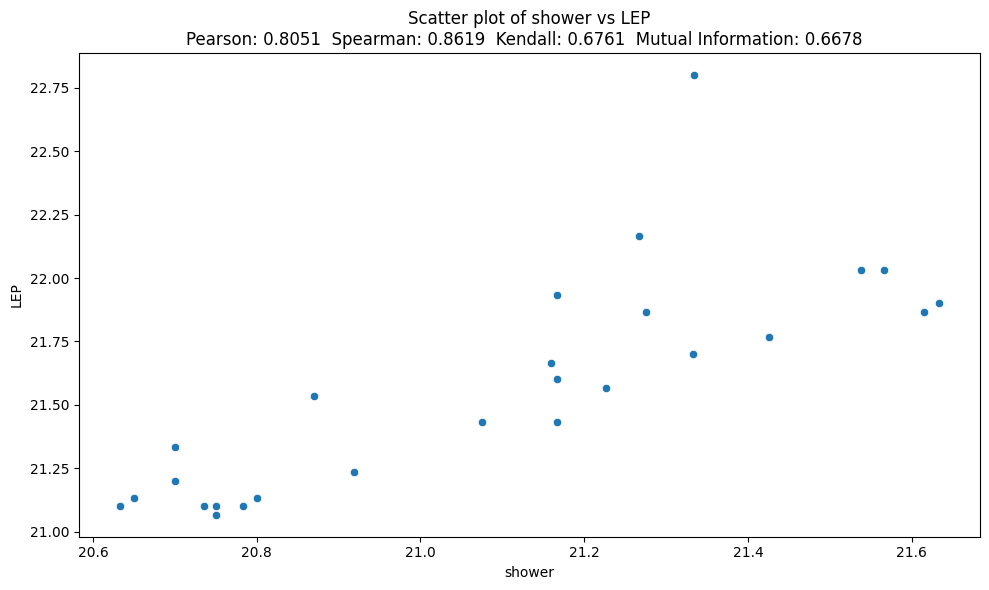

AttributeError: 'Series' object has no attribute 'categories'

<Figure size 1000x600 with 0 Axes>

In [127]:
# After 8pm
df_after_8 = df[df['shower'] >= 20.25]
results = stats_two_variables.calculate_correlations(df_after_8, c1, c2)
stats_two_variables.visualize_scatter(df_after_8, c1, c2, results)
stats_two_variables.visualize_joint_plot(df_after_8, c1, c2)
results

# Look for horizontal threshold where linear model works better
Works great for shower vs LEP, probbly not for others

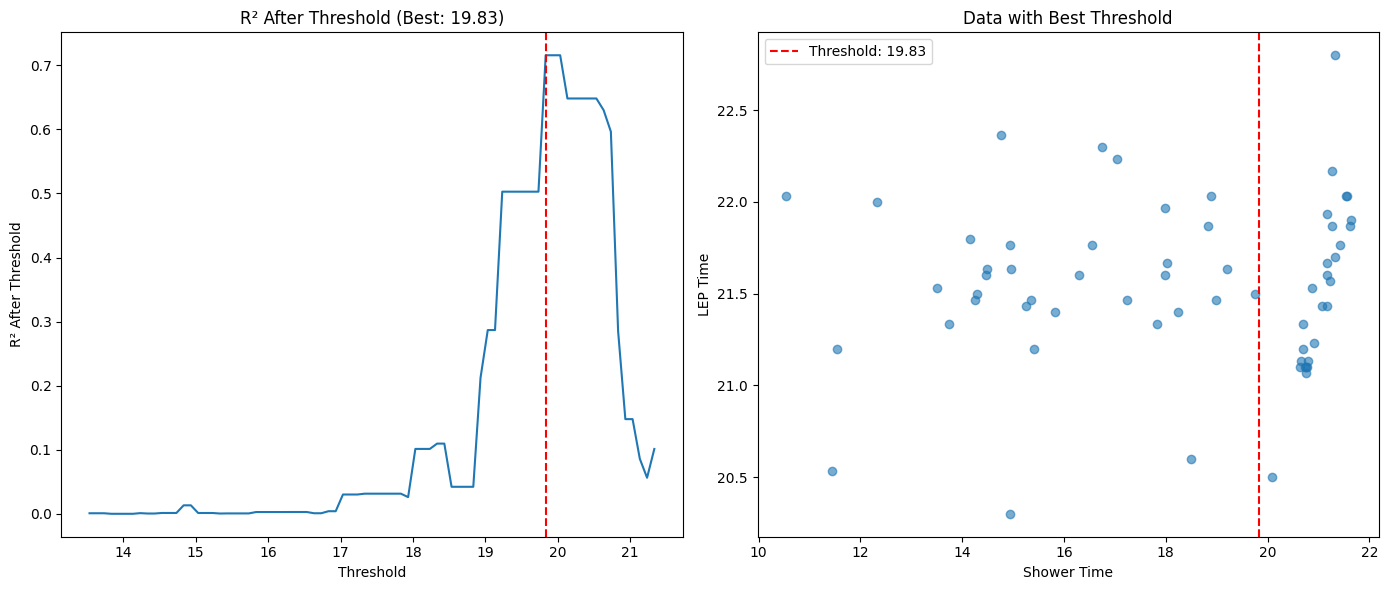

(np.float64(19.8333333333333),
     threshold  points_after  points_before  r2_after  mean_after  std_after
 0   13.533333            57              5  0.001157   21.554971   0.437897
 1   13.633333            57              5  0.001157   21.554971   0.437897
 2   13.733333            57              5  0.001157   21.554971   0.437897
 3   13.833333            56              6  0.000315   21.558929   0.440778
 4   13.933333            56              6  0.000315   21.558929   0.440778
 ..        ...           ...            ...       ...         ...        ...
 74  20.933333            15             47  0.147979   21.851111   0.329953
 75  21.033333            15             47  0.147979   21.851111   0.329953
 76  21.133333            14             48  0.086041   21.880952   0.321384
 77  21.233333             9             53  0.056551   22.014815   0.308765
 78  21.333333             7             55  0.101426   22.014286   0.340801
 
 [79 rows x 6 columns])

In [128]:
import stats_two_variables
reload(stats_two_variables)

X = df[c1].values.reshape(-1, 1)
y = df[c2].values

stats_two_variables.find_optimal_threshold(X, y)

# Machine learning

Decision Tree Rules:
|--- shower <= 21.25
|   |--- shower <= 19.92
|   |   |--- value: [21.56]
|   |--- shower >  19.92
|   |   |--- value: [21.29]
|--- shower >  21.25
|   |--- shower <= 21.38
|   |   |--- value: [22.13]
|   |--- shower >  21.38
|   |   |--- value: [21.92]



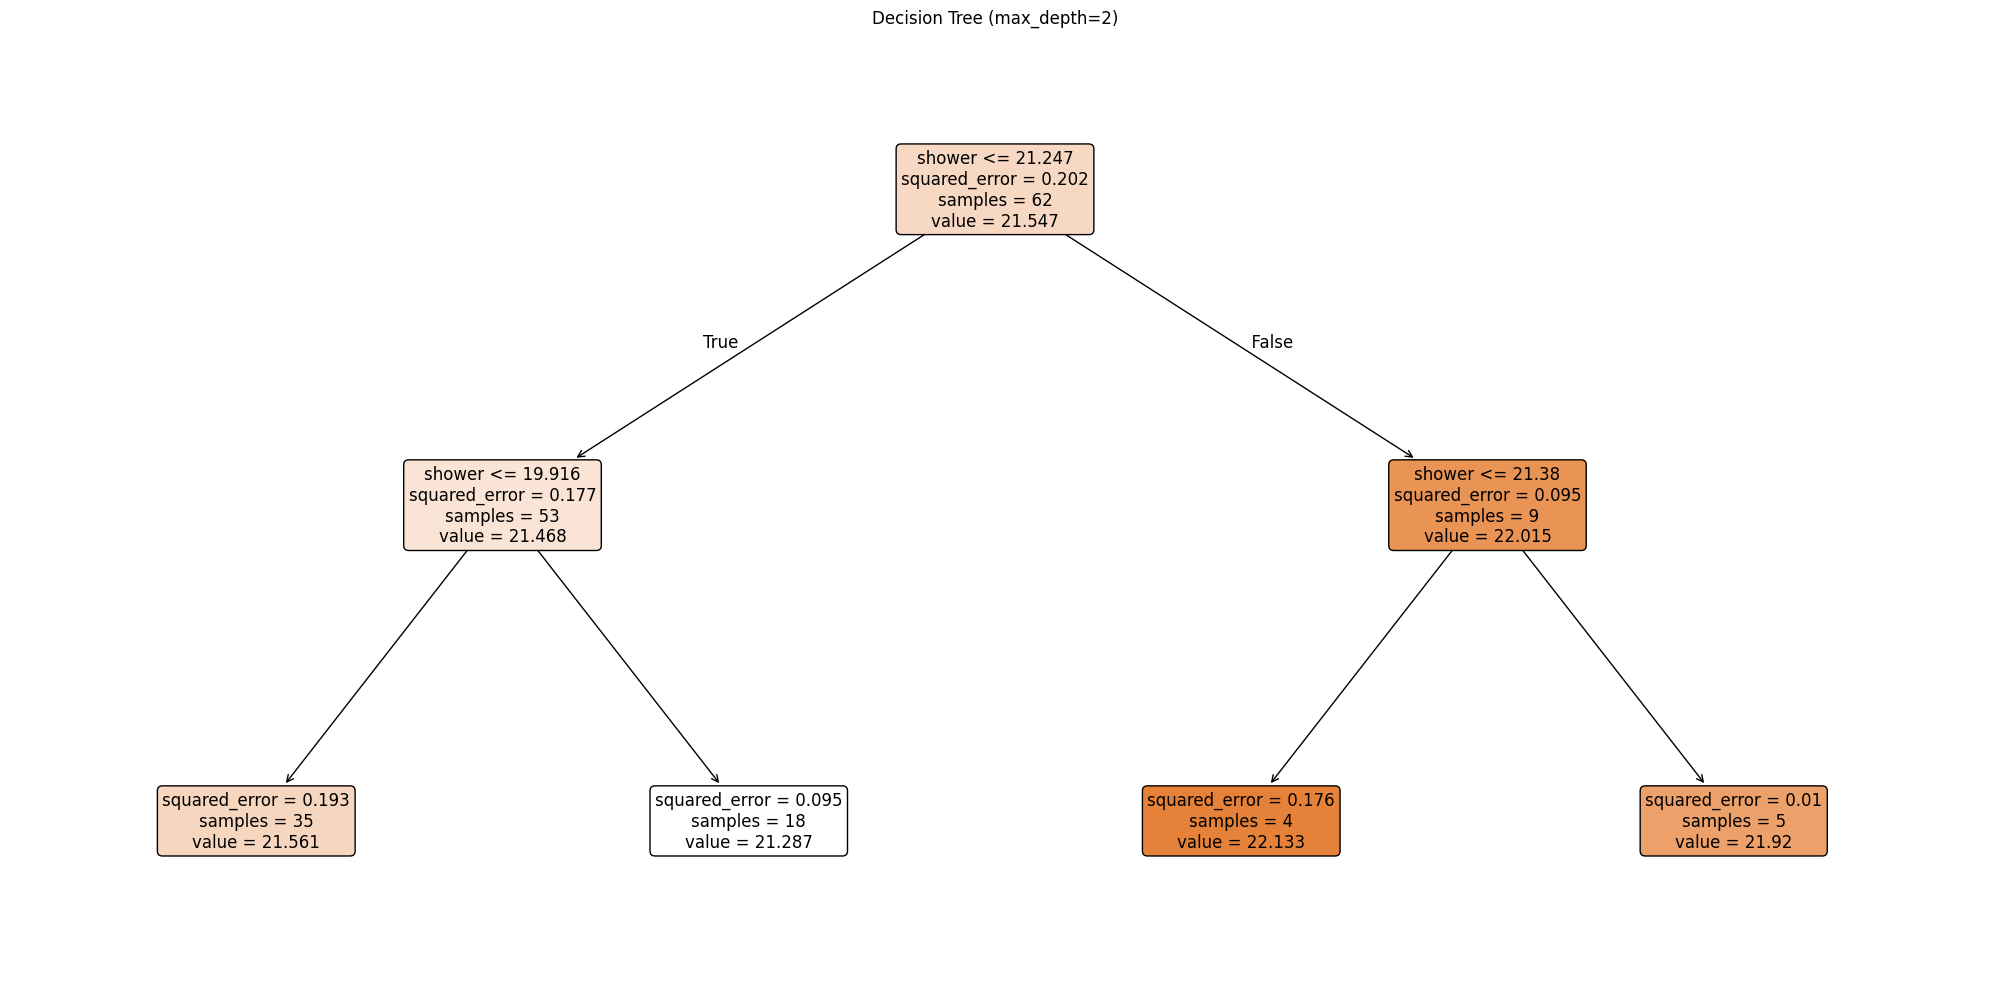

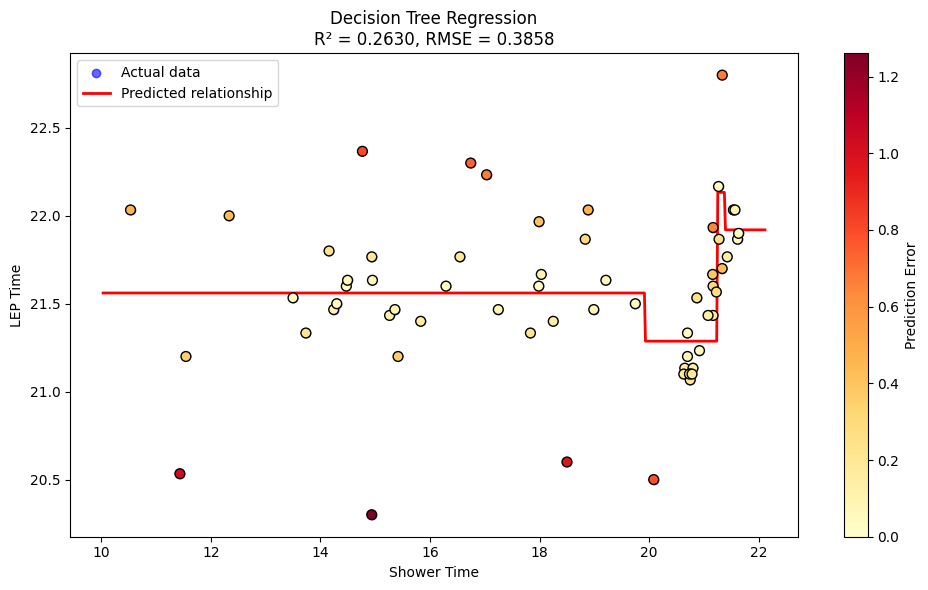

Finding optimal subsets for Decision Tree...


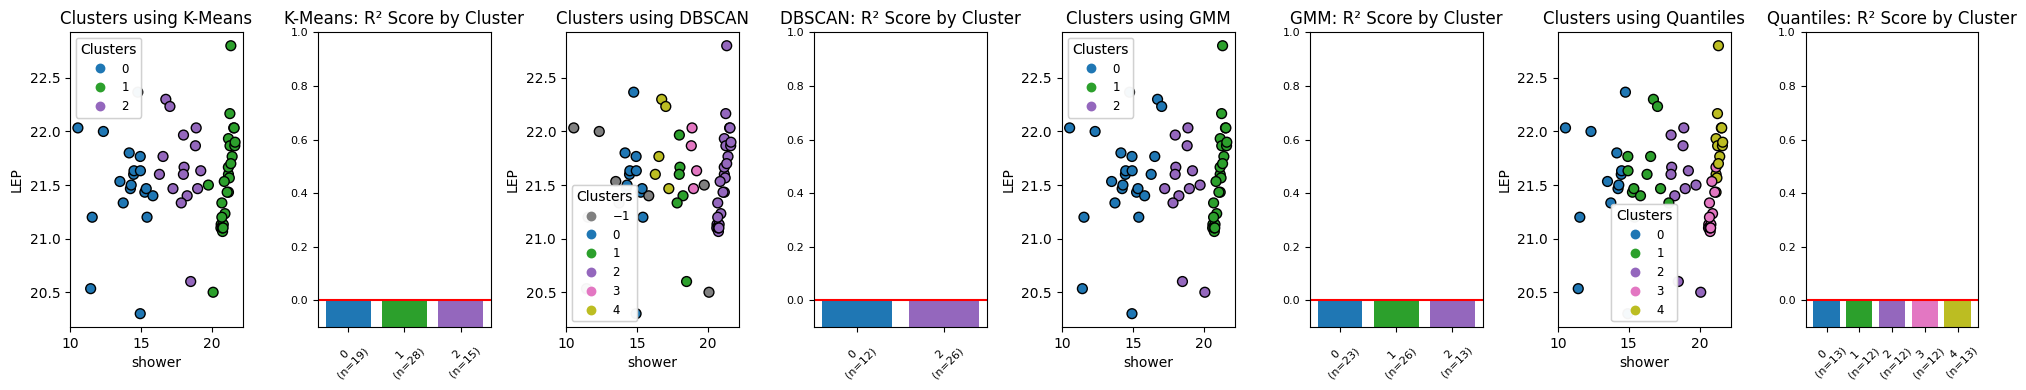

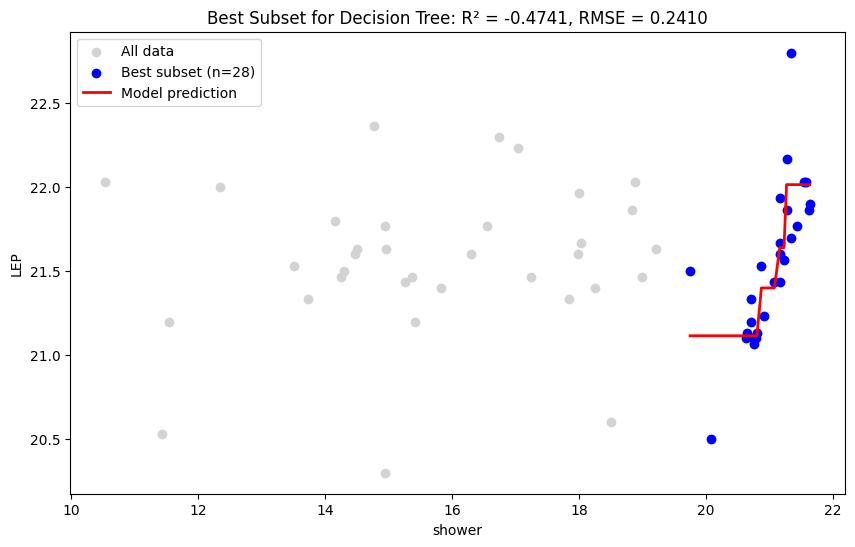

Best subset found using K-Means:
R² score: -0.4741
RMSE: 0.2410
Subset size: 28 points (45.2% of data)
shower range: 19.75 to 21.63
Decision Tree Regression Results:
R² score: 0.2630
RMSE: 0.3858


In [129]:
import stats_two_variables
reload(stats_two_variables)

models = stats_two_variables.fit_decision_tree_regressor(df, c1, c2, max_depth=2)

c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\graha\.conda\envs\py3.13\Lib\site-package

Best Gaussian Process Kernel: RBF (ls=2.0)
Optimized kernel parameters: 0.964**2 * RBF(length_scale=1e-05)


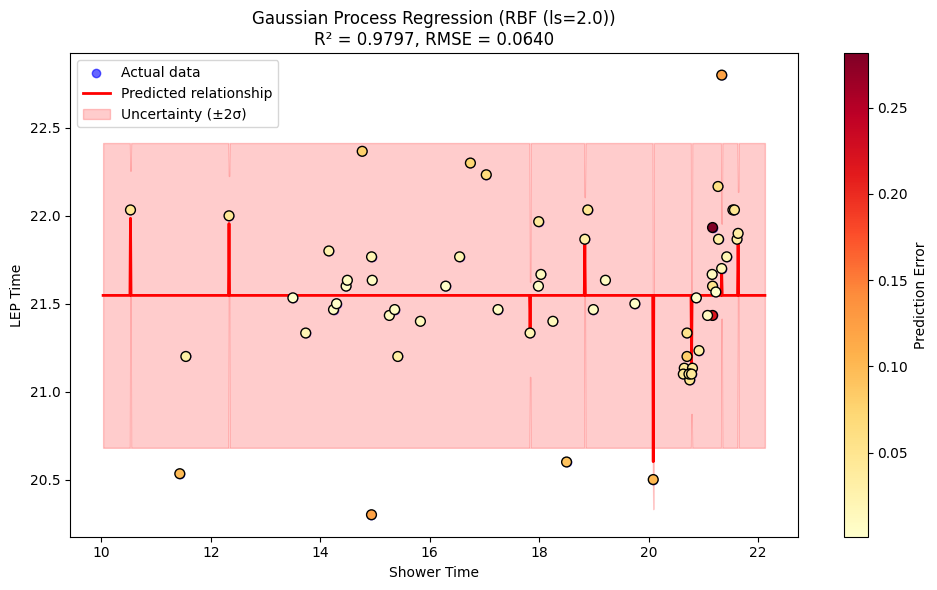

Finding optimal subsets for Gaussian Process...


c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\sklearn\g

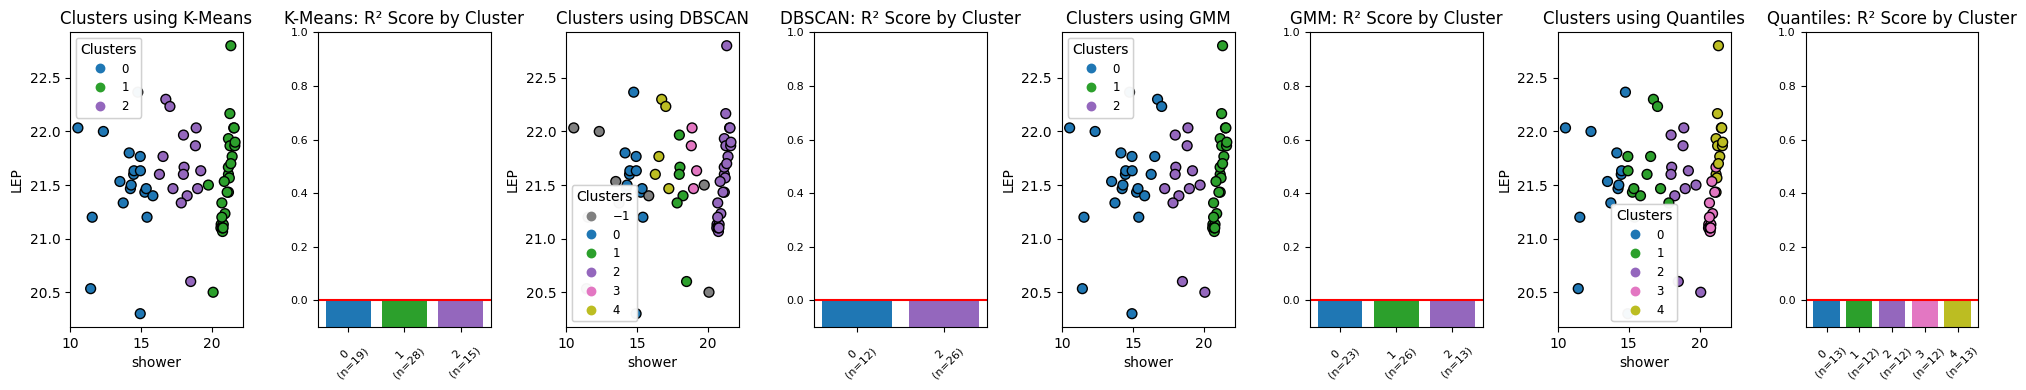

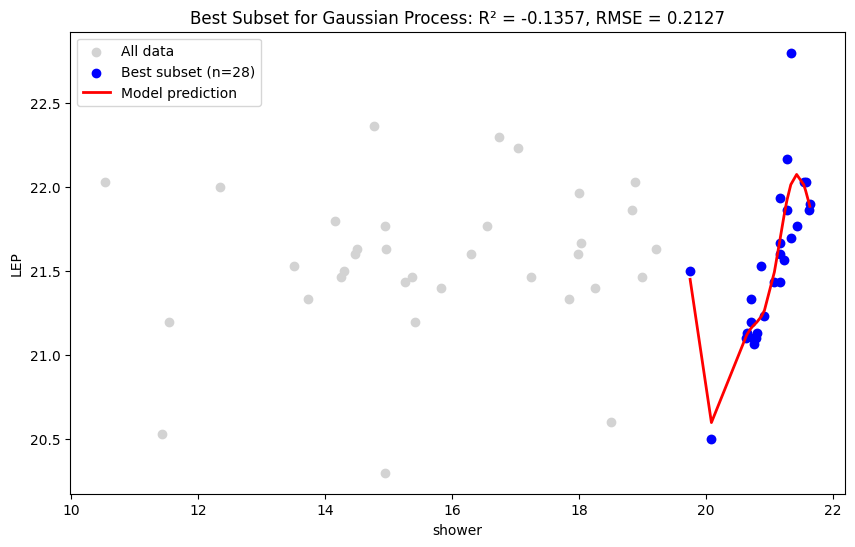

Best subset found using K-Means:
R² score: -0.1357
RMSE: 0.2127
Subset size: 28 points (45.2% of data)
shower range: 19.75 to 21.63
Gaussian Process Regression Results (Kernel: RBF (ls=2.0)):
R² score: 0.9797
RMSE: 0.0640


In [130]:
import stats_two_variables
reload(stats_two_variables)

models = stats_two_variables.fit_gaussian_process_regressor(df, c1, c2)

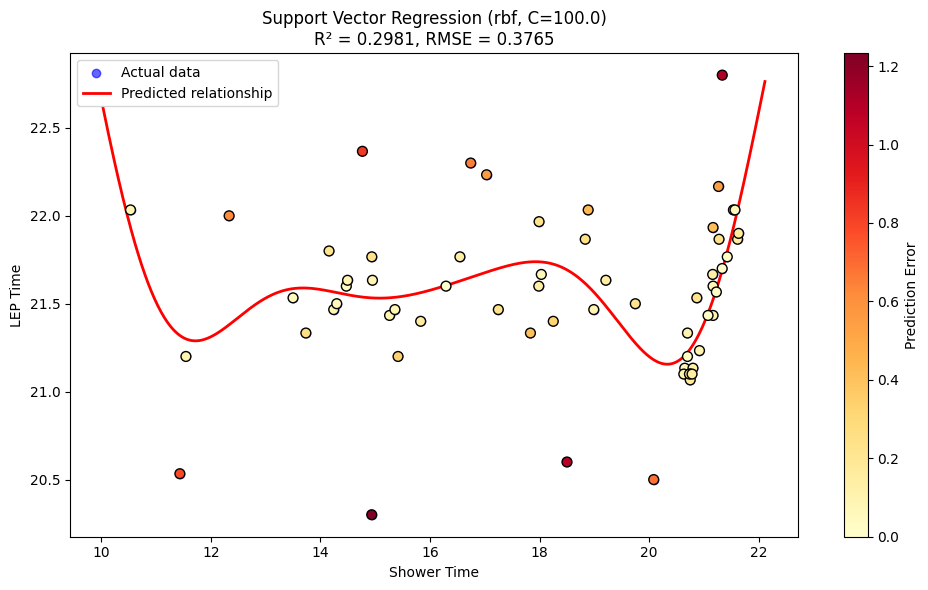

Finding optimal subsets for SVR...


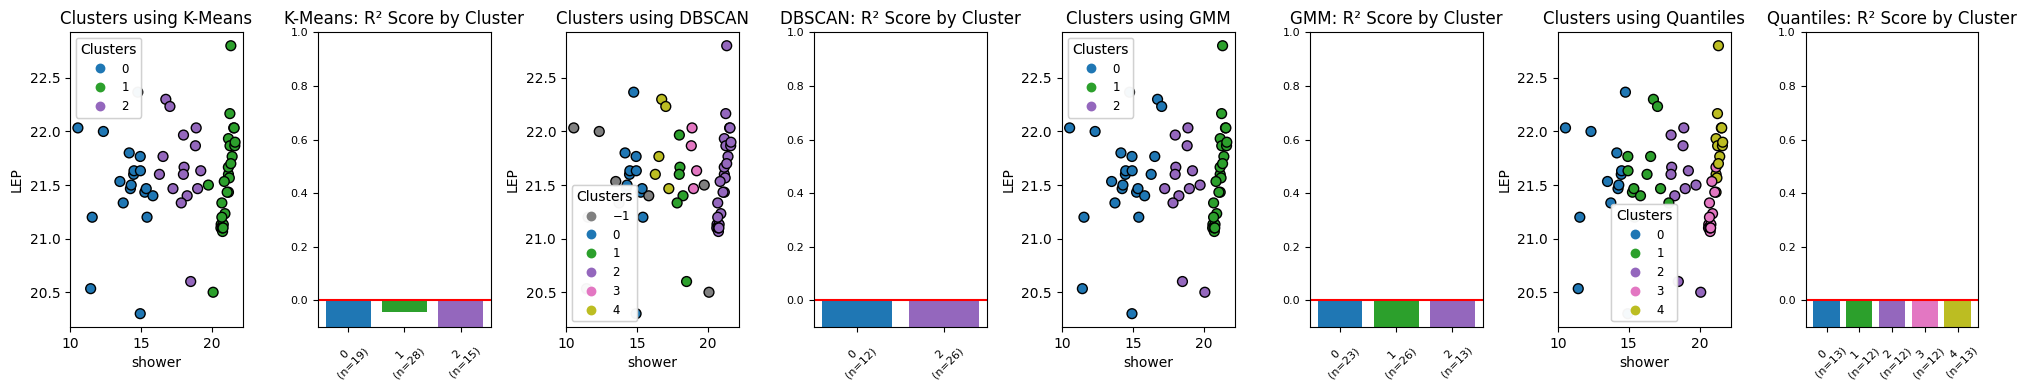

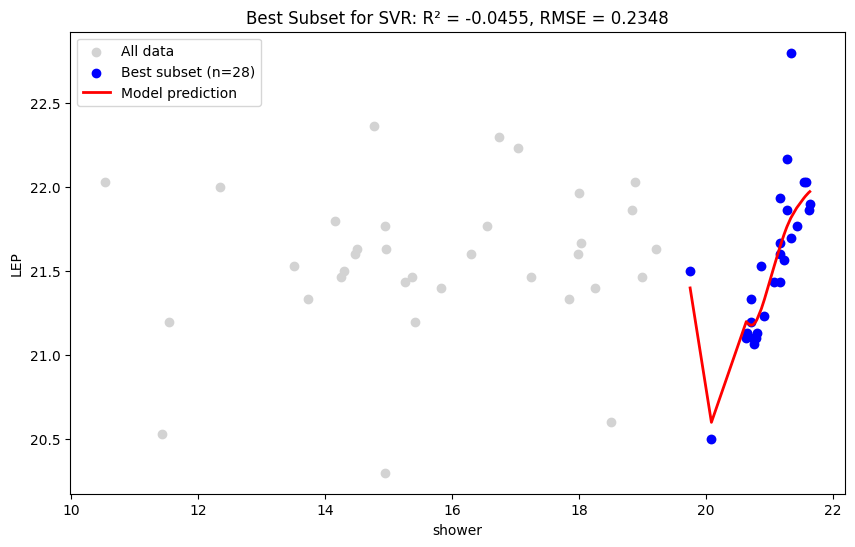

Best subset found using K-Means:
R² score: -0.0455
RMSE: 0.2348
Subset size: 28 points (45.2% of data)
shower range: 19.75 to 21.63
SVR Results (kernel=rbf, C=100.0):
R² score: 0.2981
RMSE: 0.3765


In [132]:
import stats_two_variables
reload(stats_two_variables)

models = stats_two_variables.fit_svr(df, c1, c2)

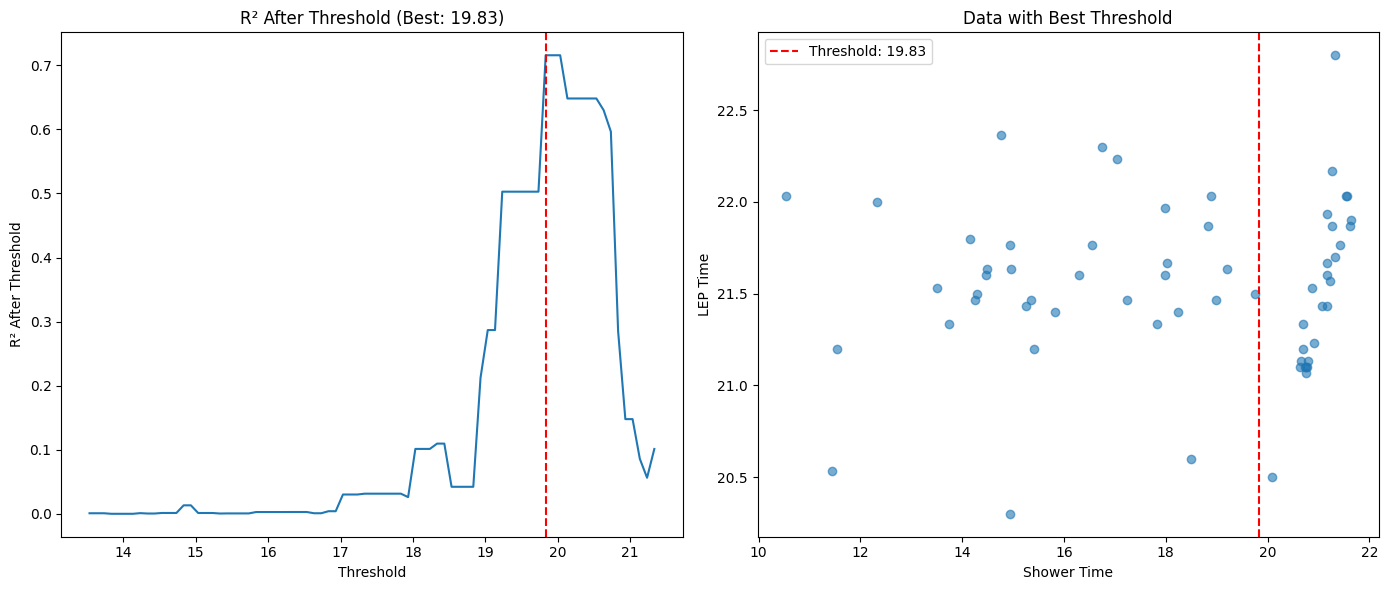

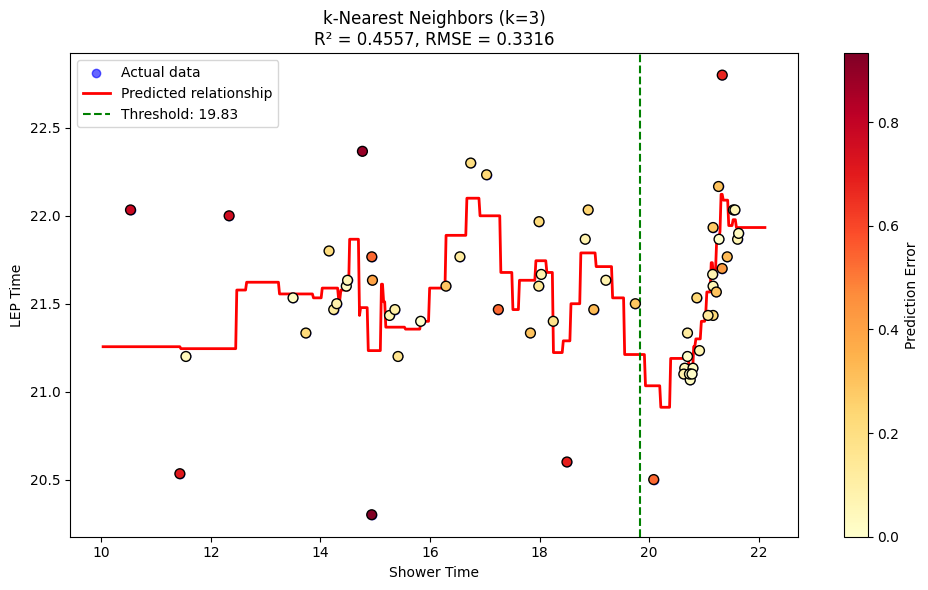

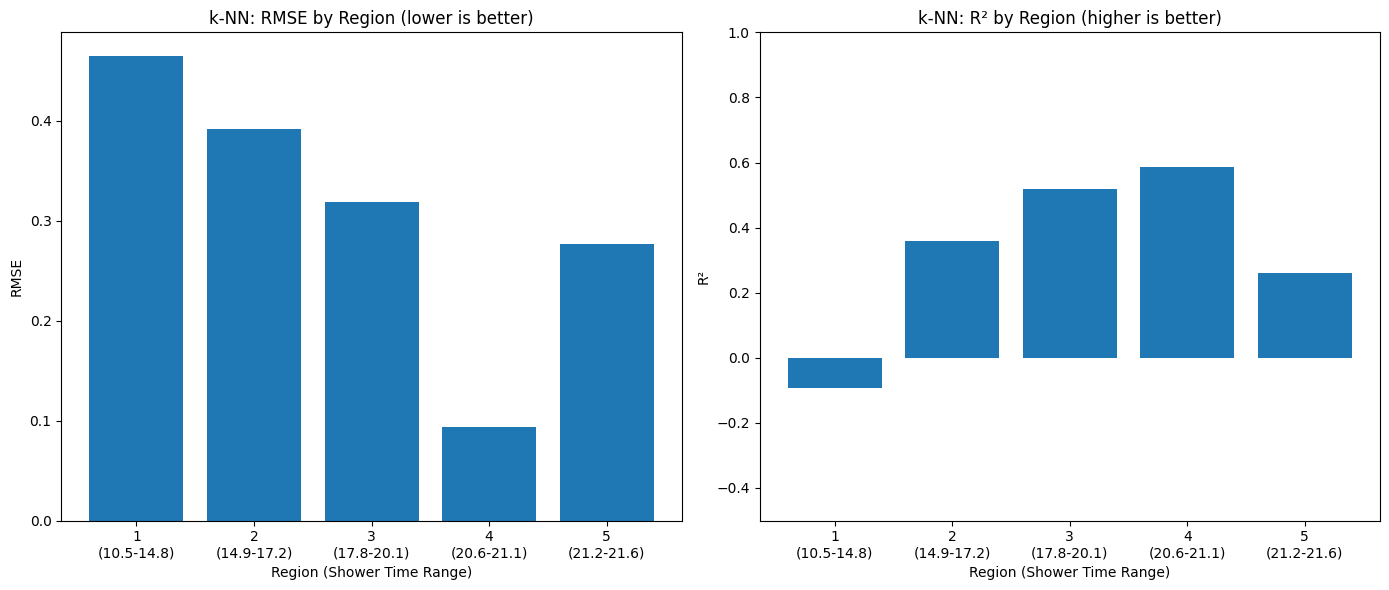

k-NN Regression Results (k=3):
R² score: 0.4557
RMSE: 0.3316


In [118]:
import stats_two_variables
reload(stats_two_variables)

models = stats_two_variables.fit_knn_regressor(df, c1, c2, n_neighbors=5)




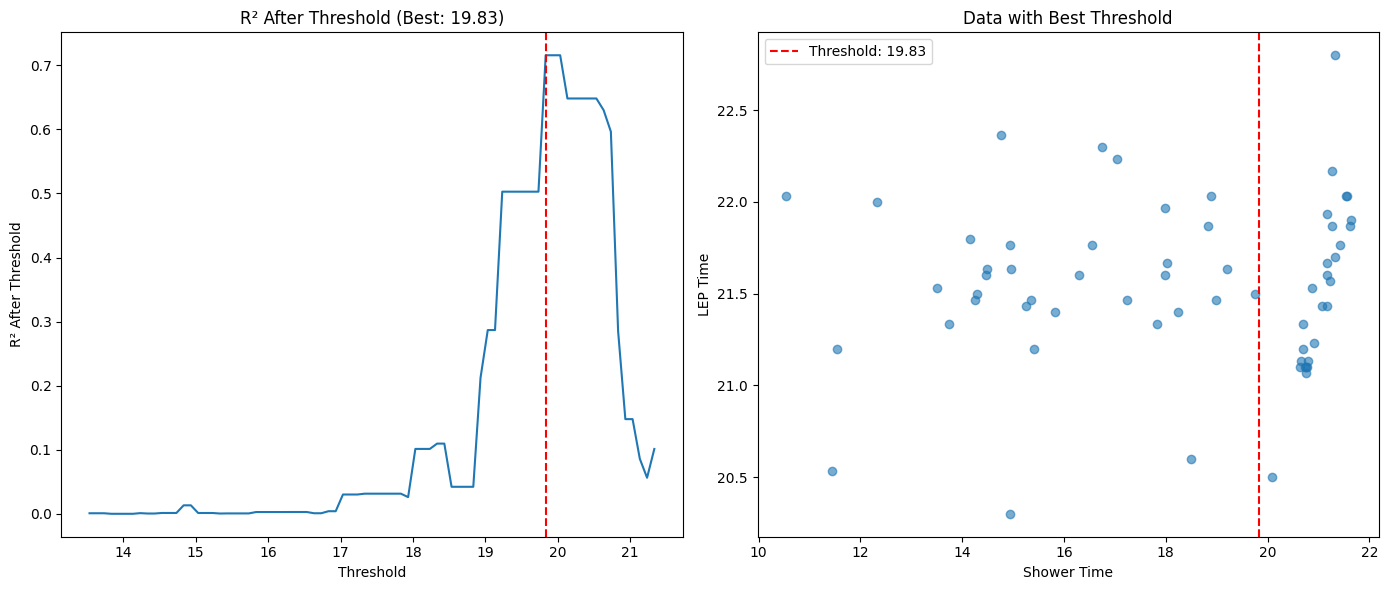

Random Forest Feature Importance: 1.0000


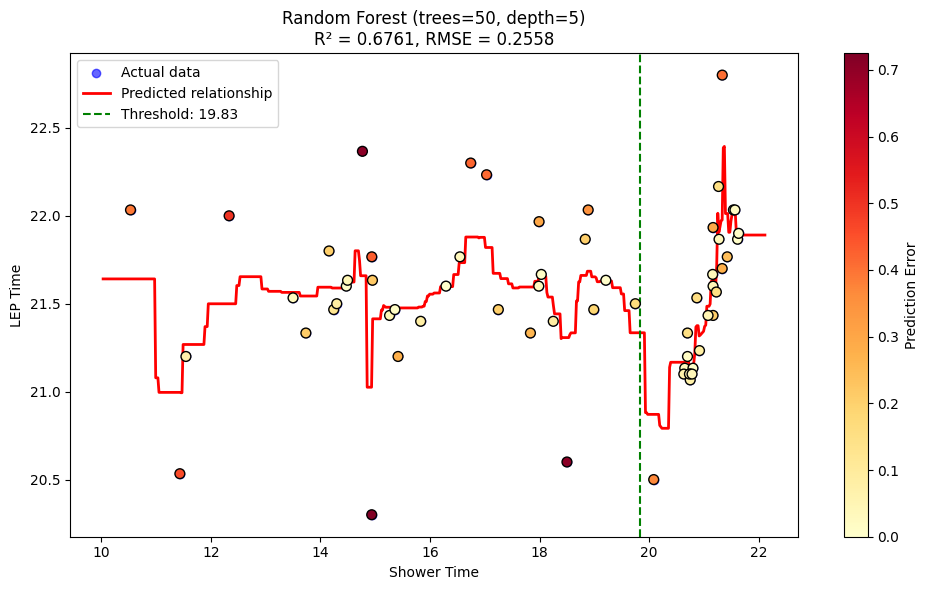

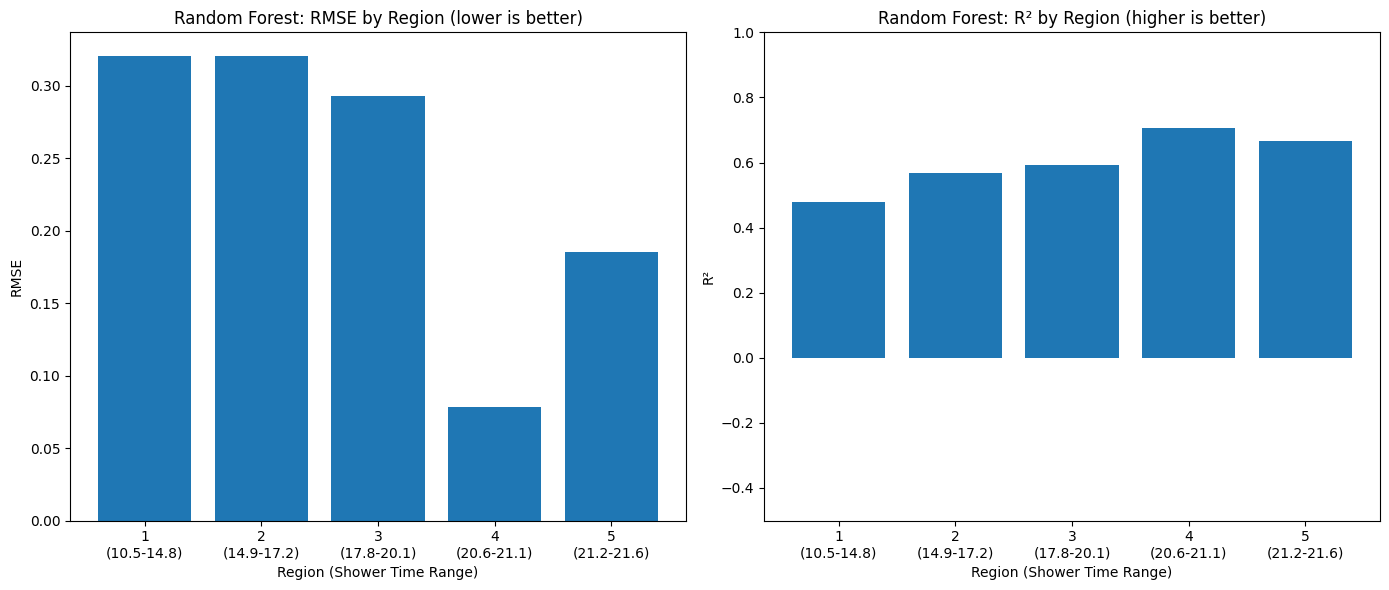

Random Forest Regression Results (trees=50, depth=5):
R² score: 0.6761
RMSE: 0.2558


In [119]:
import stats_two_variables
reload(stats_two_variables)

models = stats_two_variables.fit_random_forest_regressor(df, c1, c2, n_estimators=10, max_depth=3)


# Symbolic representation (PYSR)
Difficult-to-interpret ML slop...

In [ ]:
!pip install pysr

In [121]:
from pysr import PySRRegressor

df2 = df.copy()
df2.columns = df2.columns.str.replace(':', '_')
X = df2.drop(columns=['LEP'])
y = df2['LEP']

model = PySRRegressor(niterations=30, progress=True)
model.fit(X, y)


c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\pysr\sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           2.020e-01  1.594e+01  y = 21.547
5           2.013e-01  9.147e-04  y = (shower * 0.0086432) + 21.391
7           1.902e-01  2.816e-02  y = 21.526 - (0.18104 / (11.868 - shower))
9           1.841e-01  1.639e-02  y = 21.607 - (-1.2366 / ((19.992 - shower) * 13.418))
11          1.814e-01  7.297e-03  y = 21.568 - (-3.6907 / ((20.025 - shower) * (shower + 40....
                                      05)))
17          1.776e-01  3.540e-03  y = 21.559 - (-1.4803 / ((19.974 - shower) * (shower + (((...
                                      19.974 - shower) * shower) + 0.26171))))
21          1.659e-01  1.702e-02  y = 21.586 - (-2.5853 / ((((-2.6701 / (21.641 - shower)) *...
                                       (shower + 5.6873)) + (shower + 21.641)) * (21.003 - showe...
                                      r)))
25          1.650e-01  1.

[ Info: Final population:
[ Info: Results saved to:


PySRRegressor.equations_ = [
	   pick     score  \
	0        0.000000   
	1        0.000915   
	2  >>>>  0.028155   
	3        0.016388   
	4        0.007297   
	5        0.003540   
	6        0.017023   
	7        0.001459   
	
	                                                                                                                                                               equation  \
	0                                                                                                                                                             21.547327   
	1                                                                                                                                    (shower * 0.008643211) + 21.390783   
	2                                                                                                                       21.526142 - (0.18104248 / (11.868325 - shower))   
	3                                                                                                          21.60691 - (-1.2365829 / ((19.992218 - shower) * 13.418449))   
	4                                                                                               21.56765 - (-3.6906574 / ((20.024986 - shower) * (shower + 40.049973)))   
	5                                                         21.558786 - (-1.4803034 / ((19.974268 - shower) * (shower + (((19.974268 - shower) * shower) + 0.26171312))))   
	6                               21.585827 - (-2.5853252 / ((((-2.6701453 / (21.64149 - shower)) * (shower + 5.687273)) + (shower + 21.641493)) * (21.002783 - shower)))   
	7  21.585827 - (-2.5853252 / (((((21.002783 - shower) * 21.641493) + 21.524324) + ((-2.6701453 / (21.641493 - shower)) * (shower + 5.687273))) * (21.002783 - shower)))   
	
	       loss  complexity  
	0  0.201991           1  
	1  0.201253           5  
	2  0.190234           7  
	3  0.184100           9  
	4  0.181432          11  
	5  0.177619          17  
	6  0.165928          21  
	7  0.164962          25  
]

  - outputs\20250421_151041_wCB2KQ\hall_of_fame.csv


In [122]:
feature_list = df.columns
mapping = {f'x{i}': name for i, name in enumerate(feature_list)}

import re

def replace_vars(equation, mapping):
    for k, v in mapping.items():
        equation = re.sub(rf'\b{k}\b', v, equation)
    return equation

readable_eqs = [replace_vars(eq, mapping) for eq in model.equations_["equation"]]
readable_eqs



['21.547327',
 '(shower * 0.008643211) + 21.390783',
 '21.526142 - (0.18104248 / (11.868325 - shower))',
 '21.60691 - (-1.2365829 / ((19.992218 - shower) * 13.418449))',
 '21.56765 - (-3.6906574 / ((20.024986 - shower) * (shower + 40.049973)))',
 '21.558786 - (-1.4803034 / ((19.974268 - shower) * (shower + (((19.974268 - shower) * shower) + 0.26171312))))',
 '21.585827 - (-2.5853252 / ((((-2.6701453 / (21.64149 - shower)) * (shower + 5.687273)) + (shower + 21.641493)) * (21.002783 - shower)))',
 '21.585827 - (-2.5853252 / (((((21.002783 - shower) * 21.641493) + 21.524324) + ((-2.6701453 / (21.641493 - shower)) * (shower + 5.687273))) * (21.002783 - shower)))']